# Transfer Learning

Taking the parameter of other model(pre-trained model) learned into our model.


In [84]:
import torch
import torchvision
import random

torch.__version__, torchvision.__version__

('1.13.1', '0.14.1')

# Setup device-agnostic

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Set directory path

In [3]:
from pathlib import Path

image_dir = Path("../data/pizza_steak_sushi")
train_dir = image_dir / "train"
test_dir = image_dir / "test"
image_dir, train_dir, test_dir

(WindowsPath('../data/pizza_steak_sushi'),
 WindowsPath('../data/pizza_steak_sushi/train'),
 WindowsPath('../data/pizza_steak_sushi/test'))

# 2. Create Dataset and DataLoaders

There's one thing we have to think about when loading :how to **transform** it?
1. Manually create transforms - we cna define the transform that we want your data to go through.
2. Automatically created transforms - the transform for your data are defined by the model.

**Important**:
when using a pretrained model ,its important that the data (including you custom data) that you pass through the model **must go through the same process that the model was trained on.**

## 2.1 Creating a transform for `torchvision.models` (Manual creation)

`torchvision.models` that contain pretrained models.

>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize

refer for :[how to normalize data before put data into pretrained model](https://pytorch.org/vision/0.12/models.html)

In [4]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224,)),
    transforms.ToTensor(),
    normalize
])

In [5]:
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               batch_size=32,
                                                                               transform=manual_transforms)

In [6]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e072370eb0>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Creating a transform for `torchvision.models` (Auto Creation)

in torch version - V0.13+ provide the automatic data transformation based on the pretrained model weight we are using.

### 2.2.1 Multi-Weight Support API
**KeyPoints**
1. We can use the multiple weights.
2. It provides the preprocess step for data.

[Refer for more details - Multi-Weight Support API](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/)

In [14]:
from torchvision.models import ResNet50_Weights

# we can access the preprocessor transformer
ResNet50_Weights.IMAGENET1K_V2.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
# which tell us about the best weights
ResNet50_Weights.DEFAULT

ResNet50_Weights.IMAGENET1K_V2

In [12]:
# we can access the meta data
for k, v in ResNet50_Weights.DEFAULT.meta.items():
    if k == "categories":
        continue
    print(k, v)

min_size (1, 1)
num_params 25557032
recipe https://github.com/pytorch/vision/issues/3995#issuecomment-1013906621
_metrics {'ImageNet-1K': {'acc@1': 80.858, 'acc@5': 95.434}}
_docs 
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            


### 2.2.2 Using the New API to get the transform

In [15]:
# get set of pretrained model weights

# "DEFAULT" = best available weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [16]:
# get the transform used to created our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [18]:
# create dataloader using automatic transform
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e07406d220>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model

There are various place to get a pretrained model such as :
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models) [refer](https://github.com/rwightman/pytorch-image-models)
3. HuggingFace Hub [refer](https://huggingface.co/)
4. Paperswithcode [refer](https://paperswithcode.com/)

## 3.2 Setting up pretrain model

We want to create instance of EfficientNetB0. [Refer](https://pytorch.org/vision/stable/models/efficientnet.html)

In [19]:
# old way of creating a pretrained model
model_old = torchvision.models.efficientnet_b0(pretrained=True)

C:\Users\Lenovo\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [51]:
# new way to get the pretrained model with weights
model = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Model contain the three layers:
1. `Feature Extractor Layer` -- It is sequence of layer that will learn how to represent the input data , by identify the different feature of the image and how to represent them.It's simply squashing the image from top layer to bottom layer. So it can understand the different way to represent the image.
2. `AvgPool Layer` -- It turn the feature learned by the feature layer into feature vector.
3. `Classfier` -- It turn the feature vector into prediction logits . We usually modify this layer to depending upon oru problems.

In [52]:
from torch import nn

# feature layer
print(
    f"Number of layer in the feature block : {len([module for module in model.features.modules() if not isinstance(module, nn.Sequential)])}")
print(
    f"Number of layer in the avgpool block : {len([module for module in model.avgpool.modules() if not isinstance(module, nn.Sequential)])}")
print(
    f"Number of layer in the classifier block : {len([module for module in model.classifier.modules() if not isinstance(module, nn.Sequential)])}")

Number of layer in the feature block : 259
Number of layer in the avgpool block : 1
Number of layer in the classifier block : 2


In [53]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [54]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## 3.3 Different Type of Transfer learning

1. `Feature Extraction` --> We keep the feature layer frozen , weight won't update during the training process.Only we change the classification layer.
2. `Fine tuning` --> Some layers weight get update during the training process. this is help only when we have large dataset

<img src="../images/type_of_learning.png">

## 3.3 Getting a summary of our model using `torchinfo.summary()`

In [55]:
from torchinfo import summary

summary(model=model,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "kernel_size", "output_size", "num_params", "trainable"],
        col_width=20,
        mode="train",
        row_settings=["var_names"])

#? Trainable params: 5,288,548

Layer (type (var_name))                                      Input Shape          Kernel Shape         Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     --                   [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     --                   [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     --                   [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [3, 3]               [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    --                   [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    --           

## 3.4 Feature Extraction Learning

Since all the layer are trainable we need to freeze the feature layer to employ the feature extraction.

In [56]:
# Freeze all the base layer in EffNet
for params in model.features.parameters():
    params.requires_grad = False

In [57]:
#? we can see only the classifier layer is trainable
summary(model=model,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "kernel_size", "output_size", "num_params", "trainable"],
        col_width=20,
        mode="train",
        row_settings=["var_names"])

#? Trainable params: 1,281,000

Layer (type (var_name))                                      Input Shape          Kernel Shape         Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     --                   [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     --                   [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     --                   [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [3, 3]               [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    --                   [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    --    

In [60]:
# update the classifier block to adjust oru problem
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [59]:
summary(model=model,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "kernel_size", "output_size", "num_params", "trainable"],
        col_width=20,
        mode="train",
        row_settings=["var_names"])

#? Trainable params: 3,843

Layer (type (var_name))                                      Input Shape          Kernel Shape         Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     --                   [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     --                   [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     --                   [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [3, 3]               [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    --                   [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    --    

# 4. Train Model

In [61]:
from torchmetrics import Accuracy

# define teh loss adn optimiser
cross_entropy_loss_fn = nn.CrossEntropyLoss()
adam_optimizer = torch.optim.Adam(params=model.parameters(),
                                  lr=0.001)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [62]:
# Import train function
from going_modular import engine

# set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start timer
from timeit import default_timer as timer

start_time = timer()

# set up training
model_results = engine.train(model=model,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             loss_fn=cross_entropy_loss_fn,
                             optimizer=adam_optimizer,
                             metric_fn=accuracy_fn,
                             device=device, epochs=5)

end_time = timer()
print(f"Total Training Time : {end_time - start_time}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9756 | train_acc: 0.5437 | test_loss: 0.6792 | test_acc: 0.8818
Epoch: 2 | train_loss: 0.7330 | train_acc: 0.7688 | test_loss: 0.5558 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.5662 | train_acc: 0.8542 | test_loss: 0.4571 | test_acc: 0.8909
Epoch: 4 | train_loss: 0.4769 | train_acc: 0.8667 | test_loss: 0.4282 | test_acc: 0.9097
Epoch: 5 | train_loss: 0.4910 | train_acc: 0.8417 | test_loss: 0.3902 | test_acc: 0.9068


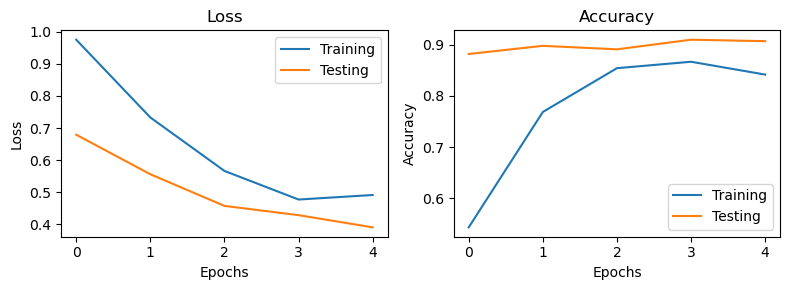

In [65]:
from going_modular import utils

utils.plot_loss_curve(model_results)

In [71]:
"pizza" in ResNet50_Weights.DEFAULT.meta["categories"]

True

Since model is trained on the pizza , that why test accuracy is grated than training accuracy.

# 5. Make prediction on image from the test set

We always keep in mind when making prediction/inference on test data/custom data .
1. Same shape as model on trained
2. Same datatype
3. Same device
4. Same transform


In [108]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt


def pred_and_plot(model_: nn.Module, image_path: Path, image_size,
                  classes_, transform, device):
    img = Image.open(image_path)

    if transform:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    model_.to(device)

    model_.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_img_logits = model_(transformed_image.to(device))

    target_img_probs = torch.softmax(target_img_logits, dim=1)

    target_pred_label = torch.argmax(target_img_probs, dim=1)

    plt.imshow(img)
    plt.title(f"Pred :{classes_[target_pred_label.cpu()]} \n Prob : {target_img_probs.max().cpu():.3f}")
    plt.axis("off")

In [100]:
all_test_image_path = list(test_dir.glob("*/*.jpg"))

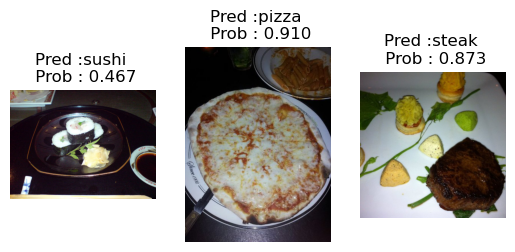

In [113]:
random_sample = random.sample(all_test_image_path, k=3)
for plt_idx, sample in enumerate(random_sample, start=1):
    plt.subplot(1, 3, plt_idx)
    pred_and_plot(model, image_path=sample,
                  image_size=224,
                  transform=auto_transforms,
                  classes_=class_names,
                  device=device)

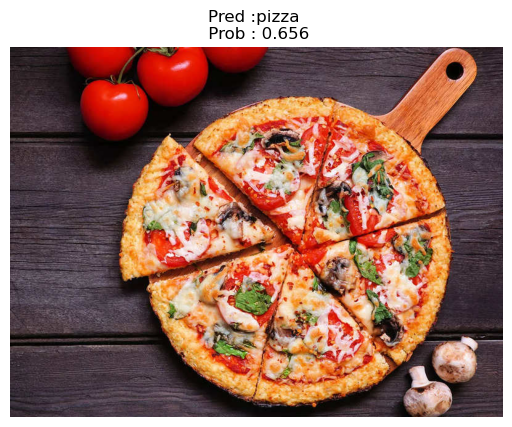

In [123]:
import requests
from io import BytesIO

response = requests.get( 'https://static.toiimg.com/thumb/msid-87930581,imgsize-211826,width-800,height-600,resizemode-75/87930581.jpg')
byte_code = BytesIO(response.content)

pred_and_plot(model, image_path=byte_code,
              image_size=224,
              transform=auto_transforms,
              classes_=class_names,
              device=device)